# 基于MindSpore实现语音识别
本小节介绍并展示了如何使用MindSpore实现语音识别。

## 1、实验目的
- 了解语音识别。
- 掌握如何使用MindSpore进行语音识别。

## 2、语音识别介绍
语音识别（Speech Recognition）是机器学习领域中的一个重要应用，旨在将人类语音转化为可理解和可处理的文本形式。它可以帮助计算机理解和处理人类的语言，从而实现自然语言交互、语音命令识别、语音转写等功能。在本实验中定义了一个神经网络，用于进行语音识别。

网络的结构如下：

1. 输入数据通过Reshape层进行形状调整，将其转换为(batch_size, 1, 124, 129)的形状。
2. 调整后的数据经过ResizeNearestNeighbor层进行大小调整，将其调整为(32, 32)的大小。
3. 调整大小后的数据通过BatchNorm2d层进行归一化处理。
4. 归一化后的数据经过一个卷积层conv1，输出通道数为32。
5. 卷积层的输出通过ReLU激活函数进行非线性变换。
6. 经过第二个卷积层conv2，输出通道数为64。
7. 第二个卷积层的输出再次经过ReLU激活函数进行非线性变换。
8. 通过最大池化层maxpool进行空间维度的下采样。
9. 经过一个Dropout层，随机地将一部分元素置为零，以避免过拟合。
10. 将经过池化和Dropout的数据展平为一维张量。
11. 展平后的数据通过一个全连接层dense1，输入通道数为12544，输出通道数为128。
12. 全连接层的输出再次经过ReLU激活函数进行非线性变换。
13. 经过第二个Dropout层，再次进行随机丢弃操作。
14. 最后通过一个全连接层dense2，输入通道数为128，输出通道数为8。
15. 最终输出得到(batch_size, 8)的张量。

这个网络使用了一些常用的神经网络层，例如卷积层、ReLU激活函数、最大池化层、Dropout层和全连接层。这些层的组合和堆叠形成了一个深层的神经网络结构，用于对输入数据进行特征提取和学习，并生成相应的输出。

网络结构图如下所示：  
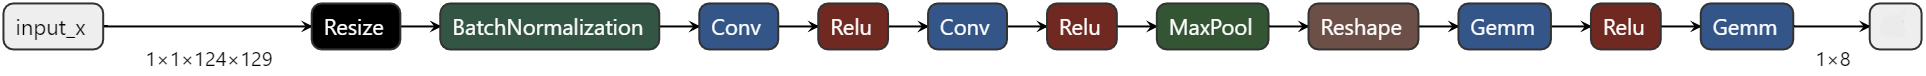

## 3、实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.4；Python环境=3.11


|  硬件平台 |  操作系统  |          软件环境           | 开发环境 | 环境搭建链接 |
| :-----:| :----: |:-----------------------:|:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、数据处理

### 4.1 处理数据集
本实验使用到了mini speech commands数据集。mini speech commands是一个用于语音识别的小型数据集，常用于学术和教育目的。它由Google团队创建，并提供给机器学习社区进行研究和开发。该数据集主要用于进行关键词识别任务，即识别特定的一组预定义关键词。这些关键词通常是日常生活中常用的命令，如"yes"、"no"、"up"、"down"、"go"、"stop"等。mini_speech_commands数据集包含了数千个短语音片段，每个片段持续约1秒，并由多个不同说话者录制。  
下面的代码提供了该数据集的下载。

In [1]:
# 使用download 来下载数据集
# !pip install download
from download import download
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"
download(url, "./data", kind="zip",replace=True)

Creating data folder...

file_sizes: 100%|████████████████████████████| 182M/182M [00:08<00:00, 22.5MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./data


'./data'

定义了一个名为 `get_spectrogram` 的函数，用于读取音频文件并进行声谱图特征提取。函数首先使用 `wav.read` 函数读取音频文件，获取采样率和波形数据。然后，它创建一个大小为 `[124, 129]` 的全零矩阵 `spectrogram`，用于存储声谱图特征。接下来，函数根据波形数据的长度计算需要添加的零填充数量，并创建一个相应长度的全零数组。然后，将波形数据和零填充数据连接起来，使其长度达到 16000。接着，函数生成一个包含从 0 到 254 的整数序列，并根据该序列计算一个窗口函数。窗口函数在数字信号处理中用于预处理音频信号。最后，函数通过遍历波形数据，并将每一帧数据进行窗口函数加窗和离散傅里叶变换，得到该帧的频谱数据。经过修改后，将频谱数据存储在 `spectrogram` 矩阵中的对应位置。最终，函数返回生成的声谱图特征 `spectrogram`。

In [2]:
import numpy as np
import scipy.io.wavfile as wav
import mindspore

mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="CPU")

# 读取文件并进行特征提取的函数
def get_spectrogram(file_path):
    fs, waveform = wav.read(file_path)
    # 声谱的矩阵大小[124,129]
    # spectrogram = np.zeros([124, 129]).astype(np.float32)
    spectrogram = np.zeros([124, 129]).astype(np.float32)
    # 边距
    zero_padding = np.zeros([16000 - waveform.shape[0]], dtype=np.float32)
    waveform = waveform.astype(np.float32)
    # 扩充到16000
    equal_length = np.concatenate([waveform, zero_padding])
    # 生成0-254每个整数
    x = np.linspace(0, 254, 255, dtype=np.int32)
    # 在数字信号处理中，加窗是音频信号预处理重要的一步
    window = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (255 - 1))
    for i in range(124):
        # 帧头
        p_start = i * 128
        # 帧尾
        p_end = p_start + 255
        frame_data = equal_length[p_start:p_end]
        frame_data = frame_data * window
        # 离散傅里叶变化
        spectrum = np.fft.rfft(frame_data, n=256)
        # 经过修改后可以使得特征输出为[124,129]
        spectrogram[i,:] = np.abs(spectrum)
    return spectrogram

处理音频文件数据集。首先从指定的数据目录中获取命令列表，然后通过随机打乱命令列表的顺序。接下来，获取所有音频文件的文件路径，并随机打乱文件路径的顺序。然后，将文件路径划分为训练集、验证集和测试集。最后，将训练集和测试集的文件路径保存到两个文本文件中，其中训练集的文件路径保存在 train_file.txt，测试集的文件路径保存在 test_file.txt。这样可以方便后续在训练和测试模型时读取相应的文件路径。  

In [3]:
import os
import random
import glob
import sys

data_dir = 'data/mini_speech_commands'

# 获取命令列表
commands = [dir_name for dir_name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, dir_name)) and dir_name != 'README.md']

# 设置随机种子
seed = 40
random.seed(seed)

# 打乱命令顺序
random.shuffle(commands)

# 获取所有文件名
all_files = []
for command in commands:
    command_path = os.path.join(data_dir, command)
    files = glob.glob(os.path.join(command_path, '*.wav'))
    all_files.extend(files)

# 打乱文件顺序
random.shuffle(all_files)

# 划分训练、验证和测试集
train_files = all_files[:6400]
val_files = all_files[6400: 6400 + 800]
test_files = all_files[-800:]

# 保存训练和测试文件列表到文件中
train_file_path = 'train_file.txt'
test_file_path = 'test_file.txt'

if sys.platform == 'win32':
    # windows系统使用如下代码
    with open(train_file_path, 'w', encoding='utf-8') as file1:
        for f in train_files:
            file1.write(f.replace('\\', '\\\\').replace('/', '\\\\') + '\n')

    with open(test_file_path, 'w', encoding='utf-8') as file2:
        for f in test_files:
            file2.write(f.replace('\\', '\\\\').replace('/', '\\\\') + '\n')
if sys.platform == 'linux':
    # Linux系统使用如下代码
    with open(train_file_path, 'w', encoding='utf-8') as file1:
        for f in train_files:
            file1.write(f + '\n')

    with open(test_file_path, 'w', encoding='utf-8') as file2:
        for f in test_files:
            file2.write(f + '\n')

这段代码的功能是从文件中读取音频文件路径，并为每个文件生成对应的音频特征数据和标签。函数首先打开指定的文件，并逐行读取文件内容。对于每一行，它会去除两端的空白字符，并提取出音频文件的路径。然后，它使用之前定义的 `get_spectrogram` 函数获取该音频文件的特征数据。接着，它从路径中提取出音频的标签，并根据标签在指定的词汇列表 `commands` 中找到对应的标签 ID。最后，函数将特征数据和标签 ID 作为生成器的输出，使用 `yield` 语句逐个返回。这样，可以在需要的时候逐个获取音频数据和标签，用于模型的训练和测试。

In [4]:
# 具体识别的8个词
commands = ['yes', 'no', 'up', 'down', 'right', 'left', 'go', 'stop']
# 获取音频标签
# 读取特征文件中的数据
def get_data(file_path):
    with open(file_path, 'r', encoding='utf8') as f:
        files = f.readlines()
    # 逐行读取
    for line in files:
        line = line.strip()
        # 提取label
        data = get_spectrogram(line) 
        if sys.platform == 'win32':
            # windows系统使用如下代码
            label = line.split('\\\\')[-2]
        if sys.platform == 'linux':
            # Linux系统使用如下代码
            label = line.split('/')[-2]        
        label_id = commands.index(label)
        # print(data,label_id,"##")
        yield np.array(data,dtype=np.float32), label_id

对训练数据集进行处理。`GeneratorDataset` 将生成器函数返回的数据转换为 MindSpore 的数据集对象，并指定了数据集中的列名为 `'data'` 和 `'label'`。`batch(64)` 对数据集进行批处理，将数据按照批次进行组织，每个批次包含 64 条数据。这样处理后的数据集可以方便地用于模型的训练。

In [5]:
import mindspore.dataset as ds

# 意为数据集本身每一条数据都可以通过索引直接访问
ds_train = ds.GeneratorDataset(list(get_data(train_file_path)), column_names=['data', 'label'])
# 批处理,分为64批
ds_train = ds_train.batch(64)

## 5、模型构建

把音频转换为语谱图后，其实就是把语音问题转化为图像问题，图像中就包含了声音的特征，这里定义了一个CV类的网络。
该网络包含了一系列的神经网络层和操作，用于构建一个分类网络。以下是简要说明：

- `conv2d(in_channels, out_channels)` 函数实现了二维卷积操作，根据输入和输出的通道数构建一个卷积层。
- `maxpool()` 函数实现了池化层，使用最大池化操作对输入进行下采样。
- `Net(Cell)` 是一个继承自 `Cell` 的网络类，用于定义网络结构。
- 在 `Net` 类的构造函数中，定义了网络中的各个层和操作，包括卷积层、激活函数、池化层、扁平化层、全连接层和 dropout 层等。
- `construct(input_x)` 方法是网络的前向传播函数，定义了数据在网络中的流动方式。具体的流程是：将输入 `input_x` 进行形状重塑、尺寸调整、批归一化、卷积、激活函数、池化、dropout、扁平化、全连接、激活函数、dropout、全连接等操作，最后输出网络的预测结果。
- 网络的输出是一个包含8个元素的向量，表示对8个不同类别的分类预测。

总体上，该网络包含了卷积层、池化层、扁平化层、全连接层和一些常用的激活函数和正则化操作，用于构建一个简单的分类网络。

In [6]:
from mindspore.nn import Conv2d
from mindspore.nn import MaxPool2d
from mindspore.nn import Cell
import mindspore.ops as P
from mindspore.nn import Dense
from mindspore.nn import ReLU
from mindspore.nn import Flatten
from mindspore.nn import Dropout
from mindspore.nn import BatchNorm2d

# 实现二维卷积操作
def conv2d(in_channels, out_channels):
    return Conv2d(in_channels=in_channels, out_channels=out_channels,
                  kernel_size=3, stride=1, pad_mode='valid',
                  has_bias=True, weight_init='he_normal')               
# 池化层
def maxpool():
    return MaxPool2d(kernel_size=(2, 2), stride=(2, 2), pad_mode='valid')

# 定义网络
class Net(Cell):
    def __init__(self, batch_size):
        super(Net, self).__init__()
        # 向网络中加层
        self.batch_size = batch_size
        self.reshape = P.Reshape()
        self.resize = P.ResizeNearestNeighbor(size=(32, 32))
        self.norm = BatchNorm2d(num_features=1)
        self.conv1 = conv2d(1, 32)
        self.relu1 = ReLU()
        self.conv2 = conv2d(32,64)
        self.relu2 = ReLU()
        self.maxpool = maxpool()
        self.dropout1 = Dropout(p=0.25)
        self.flatten = Flatten()
        self.dense1 = Dense(in_channels=12544, out_channels=128)
        self.relu3 = ReLU()
        self.dropout2 = Dropout(p=0.5)
        self.dense2 = Dense(in_channels=128, out_channels=8)
    
    def construct(self, input_x):
        x = self.reshape(input_x, (self.batch_size,1, 124, 129))
        x = self.resize(x)
        x = self.norm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return x

使用 `Adam` 优化器构建了一个优化器对象 `opt`，指定了学习率、beta 值、权重衰减等参数。使用 `SoftmaxCrossEntropyWithLogits` 创建了一个 softmax 损失函数对象 `loss_fn`，设置了稀疏标签和均值缩减方式。

In [7]:
from mindspore.nn import Adam
from mindspore.nn import SoftmaxCrossEntropyWithLogits

# 构建网络
net = Net(batch_size=64)
# 优化器
opt = Adam(net.trainable_params(), learning_rate=0.0008,
           beta1=0.9, beta2=0.999, eps=10e-8, weight_decay=0.01)
# softmax损失函数
loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True,reduction='mean')


In [8]:
def forward_fn(data, label):
    logits = net(data)
    loss = loss_fn(logits, label)
    return loss, logits

grad_fn = mindspore.value_and_grad(forward_fn, None, opt.parameters, has_aux=True)

def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    opt(grads)
    return loss

def train(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 10 == 0:
            mindspore.save_checkpoint(net, "model.ckpt")
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

## 6、模型训练

调用上述过程进行训练。

In [9]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(net, ds_train)
print("Done!")

Epoch 1
-------------------------------
loss: 2.249319  [  0/100]
loss: 1.988474  [ 10/100]
loss: 1.916067  [ 20/100]
loss: 1.950469  [ 30/100]
loss: 1.703197  [ 40/100]
loss: 1.790651  [ 50/100]
loss: 1.732156  [ 60/100]
loss: 1.756848  [ 70/100]
loss: 1.529328  [ 80/100]
loss: 1.678896  [ 90/100]
Epoch 2
-------------------------------
loss: 1.507734  [  0/100]
loss: 1.463247  [ 10/100]
loss: 1.350136  [ 20/100]
loss: 1.486118  [ 30/100]
loss: 1.484854  [ 40/100]
loss: 1.328365  [ 50/100]
loss: 1.357984  [ 60/100]
loss: 1.432723  [ 70/100]
loss: 1.443683  [ 80/100]
loss: 1.231754  [ 90/100]
Epoch 3
-------------------------------
loss: 1.286515  [  0/100]
loss: 1.346979  [ 10/100]
loss: 1.074431  [ 20/100]
loss: 1.157773  [ 30/100]
loss: 1.313322  [ 40/100]
loss: 1.187618  [ 50/100]
loss: 1.189653  [ 60/100]
loss: 1.053274  [ 70/100]
loss: 1.195102  [ 80/100]
loss: 1.158109  [ 90/100]
Epoch 4
-------------------------------
loss: 1.174381  [  0/100]
loss: 0.926454  [ 10/100]
loss: 1.

## 7、模型预测

加载已经训练好的模型，并使用该模型进行预测和计算准确率。

In [10]:
net = Net(batch_size=1)

from mindspore import load_checkpoint
from mindspore import Tensor

# 读取训练的模型文件
ckpt_file_name = "./model.ckpt"
param_dict = load_checkpoint(ckpt_file_name, net)

print("****start test****")
# 获取测试文件
batch = get_data(test_file_path) 
print(batch)
# 初始化准确率
accu = 0 
size=800

# 根据训练好的模型进行预测
for i in range(size):
    input_x, label = next(batch)
    output = net(Tensor(input_x))
    index = np.argmax(output.asnumpy())
    # 输出期望值、预测值
    print(commands[index], commands[label]) 
    if index == label:
        # 若预测成功则成功数量+1，记录预测成功的样本数量
        accu += 1      
# 准确率
print("accuracy: ", accu*1.0 / size )

****start test****
<generator object get_data at 0x000001909FD6BCD0>
up up
go right
stop stop
go go
yes right
stop stop
left right
up up
down down
up up
up stop
left no
down go
go go
left left
right right
yes yes
left left
up no
right right
yes yes
left left
go down
go go
right right
yes yes
no no
right right
go down
yes yes
yes yes
left left
go go
no no
up up
down down
stop stop
up stop
yes yes
no go
no no
down down
yes yes
right right
yes yes
stop stop
yes yes
stop stop
no no
yes yes
up up
right right
go no
up right
up up
down down
stop stop
up up
no no
no down
yes yes
right right
stop stop
left go
down down
no go
right right
go go
down down
stop stop
go go
yes yes
down down
left up
stop stop
down down
right right
stop stop
down down
right right
go go
down down
up up
down down
no no
down down
left left
stop stop
stop stop
no no
up go
go go
right right
stop stop
stop go
no no
go go
no no
down go
no no
up yes
no go
stop stop
right right
no no
right right
stop stop
down down
yes yes
yes

可以看到，最终测试集的准确率表示训练效果良好，基本达到语音识别分类目的。